In [38]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Getting vehicle classes from folder names
dataset_path = r'C:\Users\zscon\Desktop\SSE_591\repo\SSE591_Week5\SSE591_Week5\Vehicle images'
classes = os.listdir(dataset_path)
print(f'Classes: {classes}')

Classes: ['Big Truck', 'City Car', 'Truck', 'Van']


In [39]:
# Read Images and Labels (Vehicle type) into lists
images = []
labels = []

for class_name in classes:
    class_dir = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name) # constructs full path to the image file
        img = imread(img_path)                       # reads the image file into a NumPy array using skimage
        
        # Ensure the image has 3 channels (RGB)
        if len(img.shape) == 2:  # grayscale image
            img = np.stack((img,)*3, axis=-1)
        elif img.shape[2] == 4:  # RGBA image
            img = img[:, :, :3]
            
        img_resized = resize(img, (64, 64))          # resizes the image to a fixed size for consistent input for ML model
        images.append(img_resized)                   # appends resized image to images list
        labels.append(class_name)                    # appends the class name (Vehicle type) to the labels list

In [40]:
# convert lists to NumPy Arrays
X = np.array(images)        # features matrix
y = np.array(labels)        # target vector

print(f'Total images: {X.shape[0]}\
      \nImage shape: {X.shape[1:]}') # images should be 64x64; 3 represents color channels(red, green, blue)

Total images: 4567      
Image shape: (64, 64, 3)


In [41]:
Vehicle = X.reshape(X.shape[0], -1)     # convert dataset to be [n_samples, n_features]
le = LabelEncoder()                     # encode species labels
Type = le.fit_transform(y)

Xtrain, Xtest, ytrain, ytest = train_test_split(Vehicle, Type, test_size=0.3, random_state=99)

pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

model = grid.best_estimator_
yfit = model.predict(Xtest)

CPU times: total: 13min 13s
Wall time: 2min 41s
{'svc__C': 50, 'svc__gamma': 0.005}


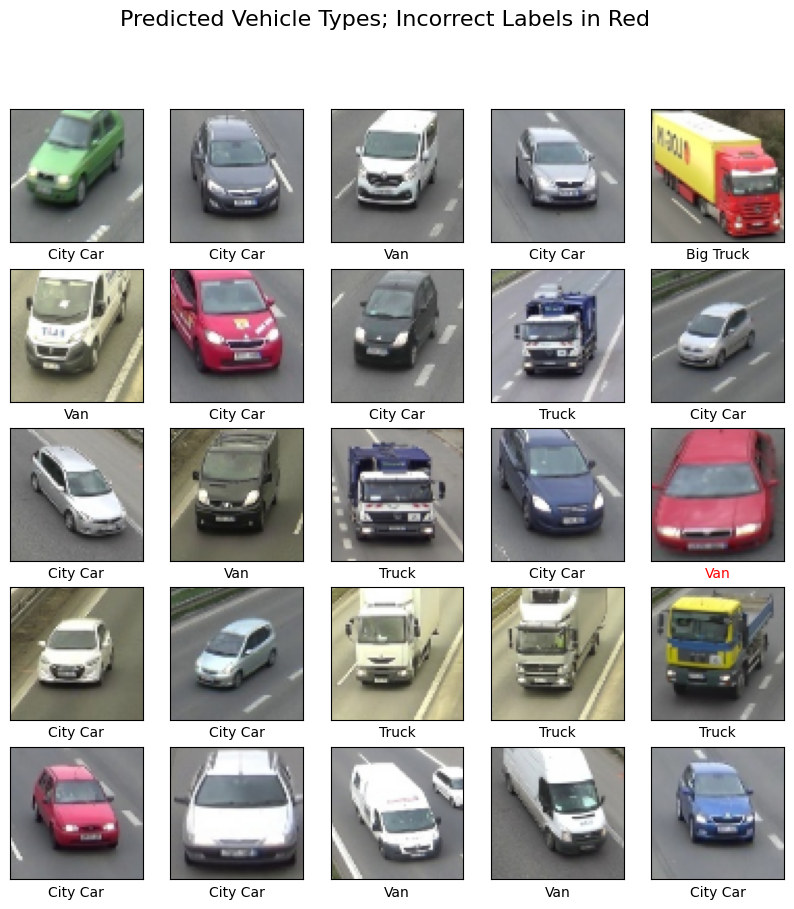

In [46]:
# Visualize the results
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(64, 64, 3))  # Reshape to 64x64x3 for display
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(le.inverse_transform([yfit[i]])[0],  # Display predicted label
                   color='black' if yfit[i] == ytest[i] else 'red')  # Color label red if prediction is incorrect

fig.suptitle('Predicted Vehicle Types; Incorrect Labels in Red', size=16);

In [43]:
print(classification_report(ytest, yfit,
                            target_names=classes))

              precision    recall  f1-score   support

   Big Truck       0.88      0.86      0.87       195
    City Car       0.94      0.96      0.95       683
       Truck       0.89      0.82      0.85       186
         Van       0.87      0.88      0.87       307

    accuracy                           0.91      1371
   macro avg       0.90      0.88      0.89      1371
weighted avg       0.91      0.91      0.91      1371



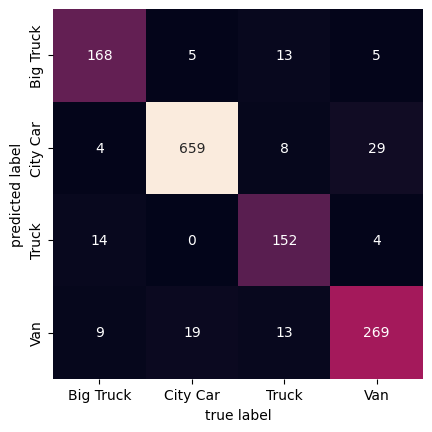

In [44]:
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label');